# Classical Methods

## Overview
- **Teaching:** 15 min
- **Exercises:** 0 min

**Questions**
- How do I get the build system?
- What are the dependencies?
- What are the main components of the build system?
- How do you `make` lessons?

**Objectives**
- Be able to fork and clone the template repository
- Understand the structure of lessons
- Know how to create environment to build lessons
- Know how to build lessons locally

**Classical molecular dynamics** (MD) is one of the most commonly applied teachniques in computational chemistry. 
In particular for the study of layer systems such as proteins, polymers, battery materials, and solar cells [[1]](#References).
These types of applications result in significant interest from users of elastic scattering techniques to assist in the data analysis process. 
In classical molecular dynamics, as you would expect, we use **classical methods** to study the **dynamics** of **molecules**.

Classical methods is the phrase used to describe all methods that use a force-field (you may hear the term potential model) to model chemical systems. 
These can be molecular dynamics, Monte Carlo, Langevin dynamics, etc. 
However, we will focus on the application in MD.
These methods are distinct from quantum mechanical methods, such as density functional theory (DFT). 
In classical methods, the quantum mechanical **weirdness** is not present, which has a significant impact on the calculation efficiency. 
The need for quantum mechanics is removed by integrating over all of the electronic orbitals and motions, and describing the atom with a **fixed electron distribution**. 
This **simplification** has some drawbacks, these are only suitable for the study of the molecular ground states, limiting the ability to study reactions. 
Futhermore, it is necessary to **describe** this electron distribution. 

## Force-fields

In practice, the model used to describe the electron distribution is usually **isotropic**, e.g. a sphere, with the electron sharing bonds between the atoms described as springs (*Figure 1*). 
The aim of a lot of chemistry/physics is to understand the **energy** of the given system, therefore it is necessary to **parameterise** out models. 
For a molecular system, the energy is defined in terms of bonded and non-bonded interactions, 

$$ E_{\text{tot}} = E_{\text{bond}} + E_{\text{angle}} + E_{\text{dihedral}} + E_{\text{non-bond}} $$

where, $E_{\text{bond}}$, $E_{\text{angle}}$, and $E_{\text{dihedral}}$ are the energies associated with all of the bonded interactions, and $E_{\text{non-bond}}$ is the energy associated with all the of the non-bonded interactions. 
This tutorial will focus **only** on the non-bonded interactions.
However, all of the parameterisation of the non-bonded interactions must also be done for bonded interactions.
<center>
    <br>
    <img src="../images/fig001.png" width="400px">
    <i>Figure 1. A pictorial example of the models used in a classical method.</i>
    <br>
</center>

The parameterisation of this force-field involves the use of **mathematical functions** to described some physical relationship. 
For example, one of the two common non-bonded interactions is the electrostatic interaction between two charged particles, to model this interaction we use **Coulomb's law**, which was first defined in 1785, 

$$ E_{\text{Coulomb}}(r_{ij}) = \frac{1}{4\pi\epsilon_0}\frac{q_iq_je^2}{r_{ij}}, $$ 

where, $q_i$ and $q_j$ are the charges on the particles, $e$ is the charge of the electron, $\epsilon$ is the dielectric permitivity of vacuum, and $r_{ij}$ is the distance between the two particles. 

The python code below defines a function that models the electrostatic interaction using Coulomb's law and plots it.

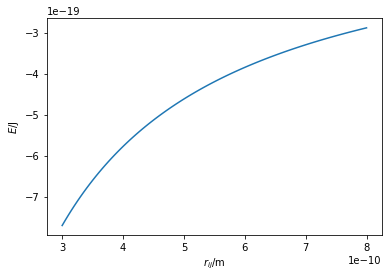

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, epsilon_0

def coulomb(qi, qj, rij):
    return 1 / (4 * np.pi * epsilon_0) * (qi * qj * e ** 2) / rij

r = np.linspace(3e-10, 8e-10, 100)
plt.plot(r, coulomb(1, -1, r))
plt.xlabel(r'$r_{ij}$/m')
plt.ylabel(r'$E$/J')
plt.show()

## Dependencies

Currently the dependencies are a conda installation (Miniconda/Anaconda).  We would recommend using an environment to manage the build system as the dependencies may grow over time to accommodate increased functionality/standardisation:
```bash
% conda create -n arc-training-bs python=3.6 jupyter 
```
Activate/deactivate the environment with 
```bash
% source activate arc-training-bs
(arc-training-bs) % source deactivate
```

Additionally the build system relies upon standard linux commands, e.g. `make`, `sed`.


## Components
The principle components of the build system are:

- `images`
- `notebooks_plain`
- `tools`

- `images` - unsurprisingly contains any images that you wish to use in the lesson either for branding or content.
- `notebooks_plain` - contain the contents of the lesson and are edited by the user.  **N.B. Take care when editing to close notebooks when adding, committing to a repository and particularly (if using them) when you switch between branches.**  More detail on the different notebook files is given in the next episode.
- `tools` - is the home of the python scripts and makefile that constitute the build system.  It also has scripts for generating `latex` and `bash` magic, as well as setting up the environment on you local machine.

## Build

The build works in three stages:

- `make render` creates rendered notebooks (from `notebooks_plain`) in `notebooks_rendered`
- `make html` renders html in `html` from `notebooks-rendered`
- `make pdf` renders pdfs in `pdf` from `html` (**Coming soon**)

If necessary dependencies and all notebooks are valid .ipynb files these commands are all that is required to build your lesson.

## Key points
- The build system consists of the tools to build and render the content
- The repository also contains the content of the lesson
- The principle depedency is Jupyter and packages that can be maintained in a virtual environment.
- The system first renders decorated notebooks->html(->pdf).

# References

1. M. Karplus and J. A. McCammon, (2012). Nat. Struct. Mol. Biol. 9, 646-652 [https://doi.org/10.1038/nsb0902-646](10.1038/nsb0902-646)
2. K. Binder, (1995). *Monte Carlo and Molecular Dynamics Simulations in Polymer Science*. Oxford, UK. Oxford University Press